In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from predcontrol_sf.control import User, Control
import predcontrol_sf.value_curves as vc
from predcontrol_sf.data_loader import load_data_bom_aus
from pathlib import Path
import datetime as dt


In [2]:
user1 = User(vc.value_curve_farmer_1, discharge_curve=vc.discharge_curve_farmer_1)
user2 = User(vc.value_curve_farmer_2)

In [3]:
ctrl = Control([user1, user2])

In [4]:
data_folder = Path(r"C:\Users\sgnodde\Documents\data\data_murray_boundary_bend")
bb_discharge = load_data_bom_aus(data_folder / 'bb_discharge.csv')
level = load_data_bom_aus(data_folder / 'bb_level.csv')

In [5]:
riverdata = pd.DataFrame({'level':level['Value'], 'discharge':bb_discharge['Value']}, index = level.index)
riverdata = riverdata.loc['2011': ]
riverdata['disch_farmer_2'] = np.NaN
riverdata['wl_farmer_1'] = np.NaN
riverdata['value'] = 0
riverdata

,level,discharge,disch_farmer_2,wl_farmer_1,value
date,,,,,
2011-01-01 00:00:00+10:00,7.216,589.060,NaN,NaN,0
2011-01-01 00:15:00+10:00,7.227,591.173,NaN,NaN,0
2011-01-01 00:30:00+10:00,7.218,589.444,NaN,NaN,0
2011-01-01 00:45:00+10:00,7.224,590.596,NaN,NaN,0
2011-01-01 01:00:00+10:00,7.213,588.485,NaN,NaN,0
...,...,...,...,...,...
2022-01-17 09:15:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:30:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:45:00+10:00,3.717,217.735,NaN,NaN,0


In [6]:
days_setting = 14
newsettingdates = [riverdata.index[4*24*days_setting]+days_setting*dt.timedelta(days=1)*i for i in range(11*int(365/days_setting))]

In [7]:
for newsettingdate in newsettingdates:
    level_weir = np.random.uniform(0,4)
    discharge = np.random.uniform(0,30)
    riverdata.loc[newsettingdate, 'wl_farmer_1'] = level_weir
    riverdata.loc[newsettingdate,'disch_farmer_2'] = discharge
riverdata

,level,discharge,disch_farmer_2,wl_farmer_1,value
date,,,,,
2011-01-01 00:00:00+10:00,7.216,589.060,NaN,NaN,0
2011-01-01 00:15:00+10:00,7.227,591.173,NaN,NaN,0
2011-01-01 00:30:00+10:00,7.218,589.444,NaN,NaN,0
2011-01-01 00:45:00+10:00,7.224,590.596,NaN,NaN,0
2011-01-01 01:00:00+10:00,7.213,588.485,NaN,NaN,0
...,...,...,...,...,...
2022-01-17 09:15:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:30:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:45:00+10:00,3.717,217.735,NaN,NaN,0


<AxesSubplot:xlabel='date'>

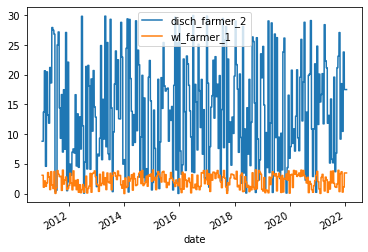

In [8]:
riverdata[['disch_farmer_2','wl_farmer_1']] = riverdata[['disch_farmer_2','wl_farmer_1']].ffill()
riverdata[['disch_farmer_2','wl_farmer_1']].plot()

In [9]:
import neat

In [10]:
generation = 0

In [38]:
config_path = "config_expl.txt"
config = neat.config.Config(neat.DefaultGenome,
                            neat.DefaultReproduction,
                            neat.DefaultSpeciesSet,
                            neat.DefaultStagnation,
                            config_path)

In [41]:
# inputs = water level, discharge now (will be more)

In [59]:
def run_control(genomes, config):
    # Init NEAT
    nets = []
    controls = []

    for id, g in genomes:
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        g.fitness = 0

        # Init my cars
        controls.append(Control([user1, user2]))


    # Main loop
    global generation
    generation += 1

    enum_nsd = iter(newsettingdates)
    ind = next(enum_nsd)

    while True:
        
        # Input my data and get result from network
        dis = riverdata['discharge'][ind]
        lev = riverdata['level'][ind]



        for i, control in enumerate(controls):
            output = nets[i].activate([dis, lev])
            
            #print(f"Output: {output}")
            dis_2, wl_1 = output

            # TODO: kill really bad control 

            value = control.return_combined_value(riverdata['level'][ind],
                                    [None, dis_2],
                                    [wl_1, None])
            # TODO: hij doet het nu maar eens per 2 weken
            # dus wel die total gebruiken!
            # maar eerst dit maar eens aan de praat krijgen
            #print(value)
            genomes[i][1].fitness += value

        ind = next(enum_nsd)
        if ind == newsettingdates[-1]:
            break

In [66]:
p = neat.Population(config)

# Add reporter for fancy statistical result
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

# Run NEAT
p.run(run_control, 200)


 ****** Running generation 0 ****** 



c:\users\sgnodde\documents\git\str-flow-pred-and-control\predcontrol_sf\physics.py:14: RuntimeWarning: invalid value encountered in power
  q = 2 / 3 * cd * b * (2 * g) ** 0.5 * h ** 1.5


Population's average fitness: -10087.76939 stdev: 10514.39559
Best fitness: 5530.43090 - size: (2, 4) - species 1 - id 15
Average adjusted fitness: 0.431
Mean genetic distance 1.167, standard deviation 0.422
Population of 30 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    30   5530.4    0.431     0
Total extinctions: 0
Generation time: 1.221 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2768.21668 stdev: 7750.53768
Best fitness: 5530.43090 - size: (2, 4) - species 1 - id 15
Average adjusted fitness: 0.698
Mean genetic distance 1.535, standard deviation 0.404
Population of 30 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    30   5530.4    0.698     1
Total extinctions: 0
Generation time: 1.048 sec (1.135 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1333.13444 stdev: 6824.40198
Best f

In [64]:
import warnings
def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()

In [67]:
plot_stats(stats, filename='v1_200x.svg')

In [90]:
# TODO: 1. training in package
# TODO: 2. running maken
# TODO: 3. running in package
# TODO: 4. voorspelalgoritme in package (train+run)
# TODO: iets meer met die activatiefunctie doen? (formule vanuit output)
# TODO: voorspelling toevoegen
# TODO: score voor hele 2 weken

In [92]:
best_genome = stats.best_genome()
best_genome.fitness

17497.973791906166

## Getraind model aan het werk

### How to use input and output

In: `output = nets[i].activate([dis, lev])`

Out: `dis_2, wl_1 = output`

In [81]:
# TODO: save to file as well
net = neat.nn.FeedForwardNetwork.create(best_genome, config)
net.activate([4,4])